In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import re

# Data source location
files = glob.glob('../ai-data-main/household_power_consumption/dataverse_files_cleaned/Residential_*.csv')

# sort files in numerical order
files.sort(key=lambda f: int(re.sub('\D', '', f)))

# split dataset in different dataframes
# each file is a residential
residentials = [pd.read_csv(f, sep=',', low_memory=False) for f in files]

print('Amount of different residentials: ' + str(len(residentials)))

Amount of different residentials: 28


In [3]:
residentials[0].head()

,Unnamed: 0,Date,Time,Latitude,Longitude,House_or_apartment,Area_of_residence,House_is_isolated,Number_of_residents,Heating_type,Solar_panels,Global_active_power
0,0,2012-06-01,01:00:00,49.210722,-126.104206,0,0,0,0,1,0,1.011
1,1,2012-06-01,02:00:00,49.210722,-126.104206,0,0,0,0,1,0,0.451
2,2,2012-06-01,03:00:00,49.210722,-126.104206,0,0,0,0,1,0,0.505
3,3,2012-06-01,04:00:00,49.210722,-126.104206,0,0,0,0,1,0,0.441
4,4,2012-06-01,05:00:00,49.210722,-126.104206,0,0,0,0,1,0,0.468


In [4]:
for i in range(len(residentials)):    
    residentials[i]['Date'] = pd.to_datetime(residentials[i]['Date'])
    residentials[i].set_index('Date', inplace=True)

    residentials[i] = residentials[i].groupby(pd.Grouper(freq='d')).mean().dropna(how='all')
    
    residentials[i] = residentials[i].drop(columns=['Unnamed: 0', 'Latitude', 'Longitude', 'House_or_apartment',
                                                    'Area_of_residence', 'House_is_isolated', 'Number_of_residents',
                                                    'Heating_type', 'Solar_panels']).copy()
    
residentials[0].head()

,Global_active_power
Date,
2012-06-01,0.846783
2012-06-02,0.847125
2012-06-03,0.951833
2012-06-04,1.067083
2012-06-05,1.005292


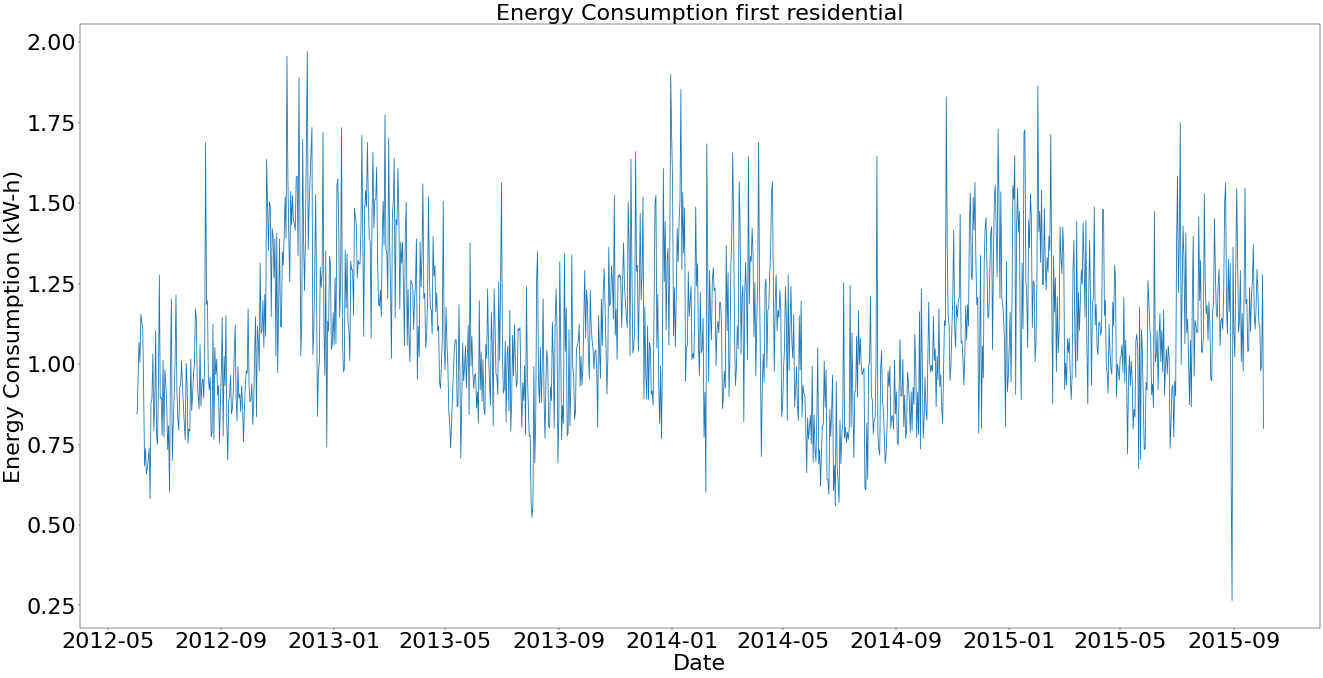

In [5]:
plt.figure(figsize=(40,20), dpi=40)
plt.locator_params(axis='x', nbins=3)
plt.xticks()
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(residentials[0].index, residentials[0]["Global_active_power"])
plt.xlabel("Date", fontsize=40)
plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
plt.title("Energy Consumption first residential", fontsize=40)
plt.show()

# Rolling Statistics


In [6]:
rollmean = residentials[0]["Global_active_power"].rolling(window=365).mean()
rollstd = residentials[0]["Global_active_power"].rolling(window=365).std()

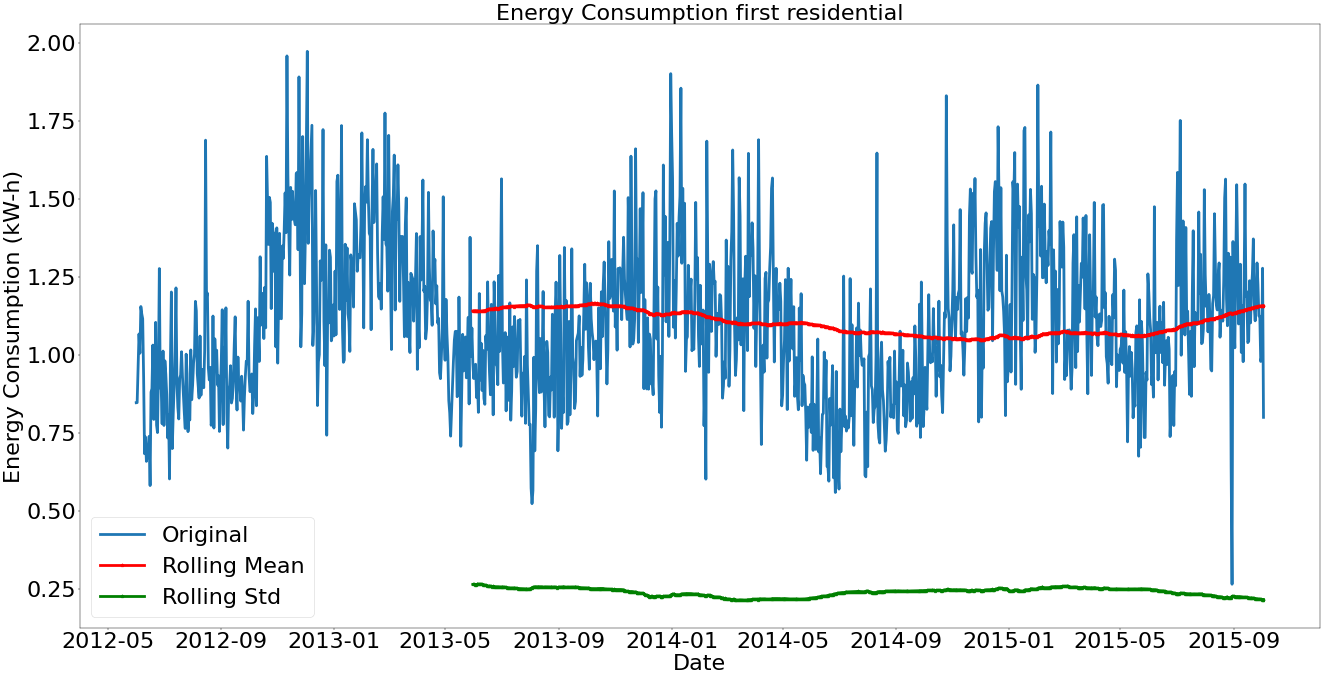

In [7]:
plt.figure(figsize=(40,20), dpi=40)
plt.locator_params(axis='x', nbins=3)
plt.xticks()
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(residentials[0].index, residentials[0]["Global_active_power"], label='Original', linewidth='5')
mean = plt.plot(residentials[0].index, rollmean, '-p', color='red', label='Rolling Mean', linewidth='5')
std = plt.plot(residentials[0].index, rollstd, '-p', color='green', label='Rolling Std', linewidth='5')
plt.xlabel("Date", fontsize=40)
plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
plt.title("Energy Consumption first residential", fontsize=40)
plt.legend(loc='best', fontsize=40)
plt.show()

# Outliers treatment

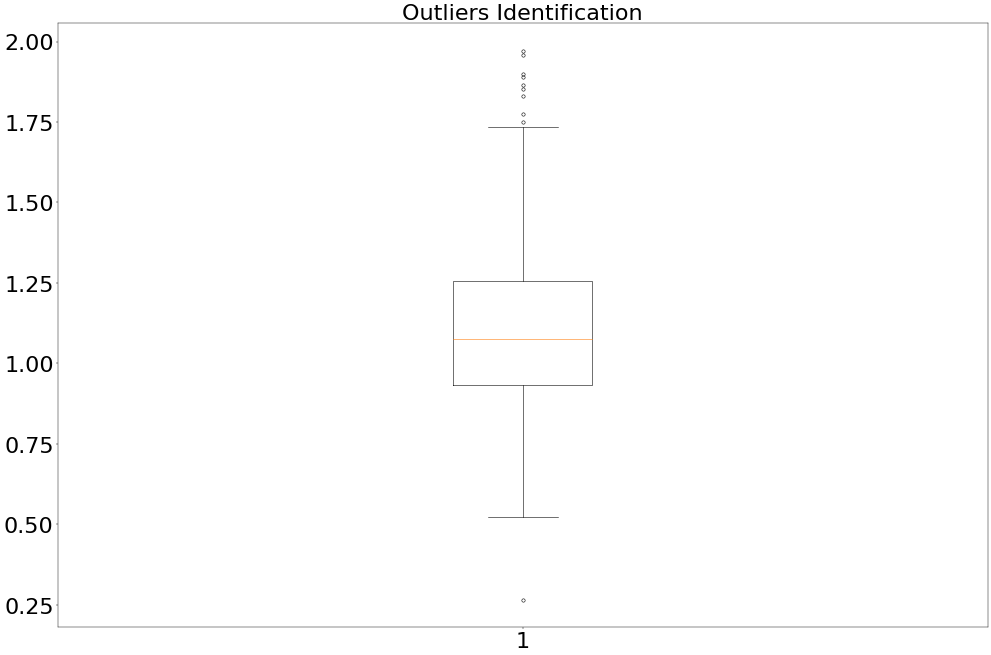

1.1047782494654312


In [8]:
plt.figure(figsize=(30,20), dpi=40)
plt.boxplot(residentials[0]["Global_active_power"])
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("Outliers Identification", fontsize=40)
plt.show()
print(residentials[0]["Global_active_power"].mean())

In [9]:
energy_cutoff = 3.5
# The following condition returns a boolean array and the sum() call adds only the true conditions
outliers_number = (residentials[0]["Global_active_power"] > energy_cutoff).sum()
outliers_density = outliers_number/len(residentials[0]["Global_active_power"])
print(f"The number of outliers is {outliers_number} and the outliers density is: {outliers_density}")

The number of outliers is 0 and the outliers density is: 0.0


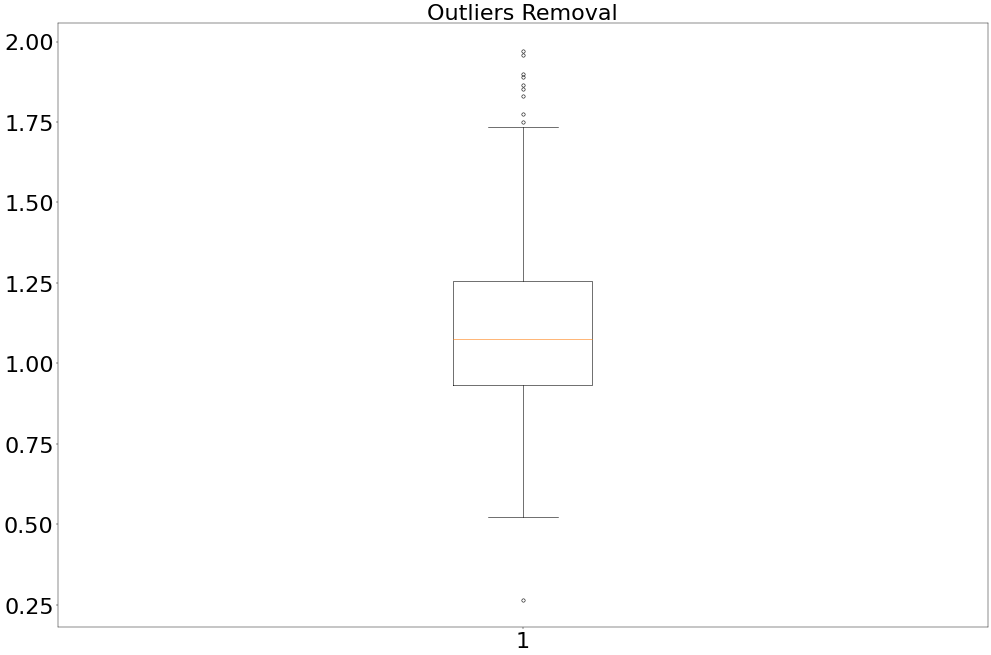

In [10]:
# Outliers removal
residentials[0].loc[residentials[0].Global_active_power > energy_cutoff, "Global_active_power"] = \
residentials[0]["Global_active_power"].mean()

plt.figure(figsize=(30,20), dpi=40)
plt.boxplot(residentials[0]['Global_active_power'])
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("Outliers Removal", fontsize=40)
plt.show()

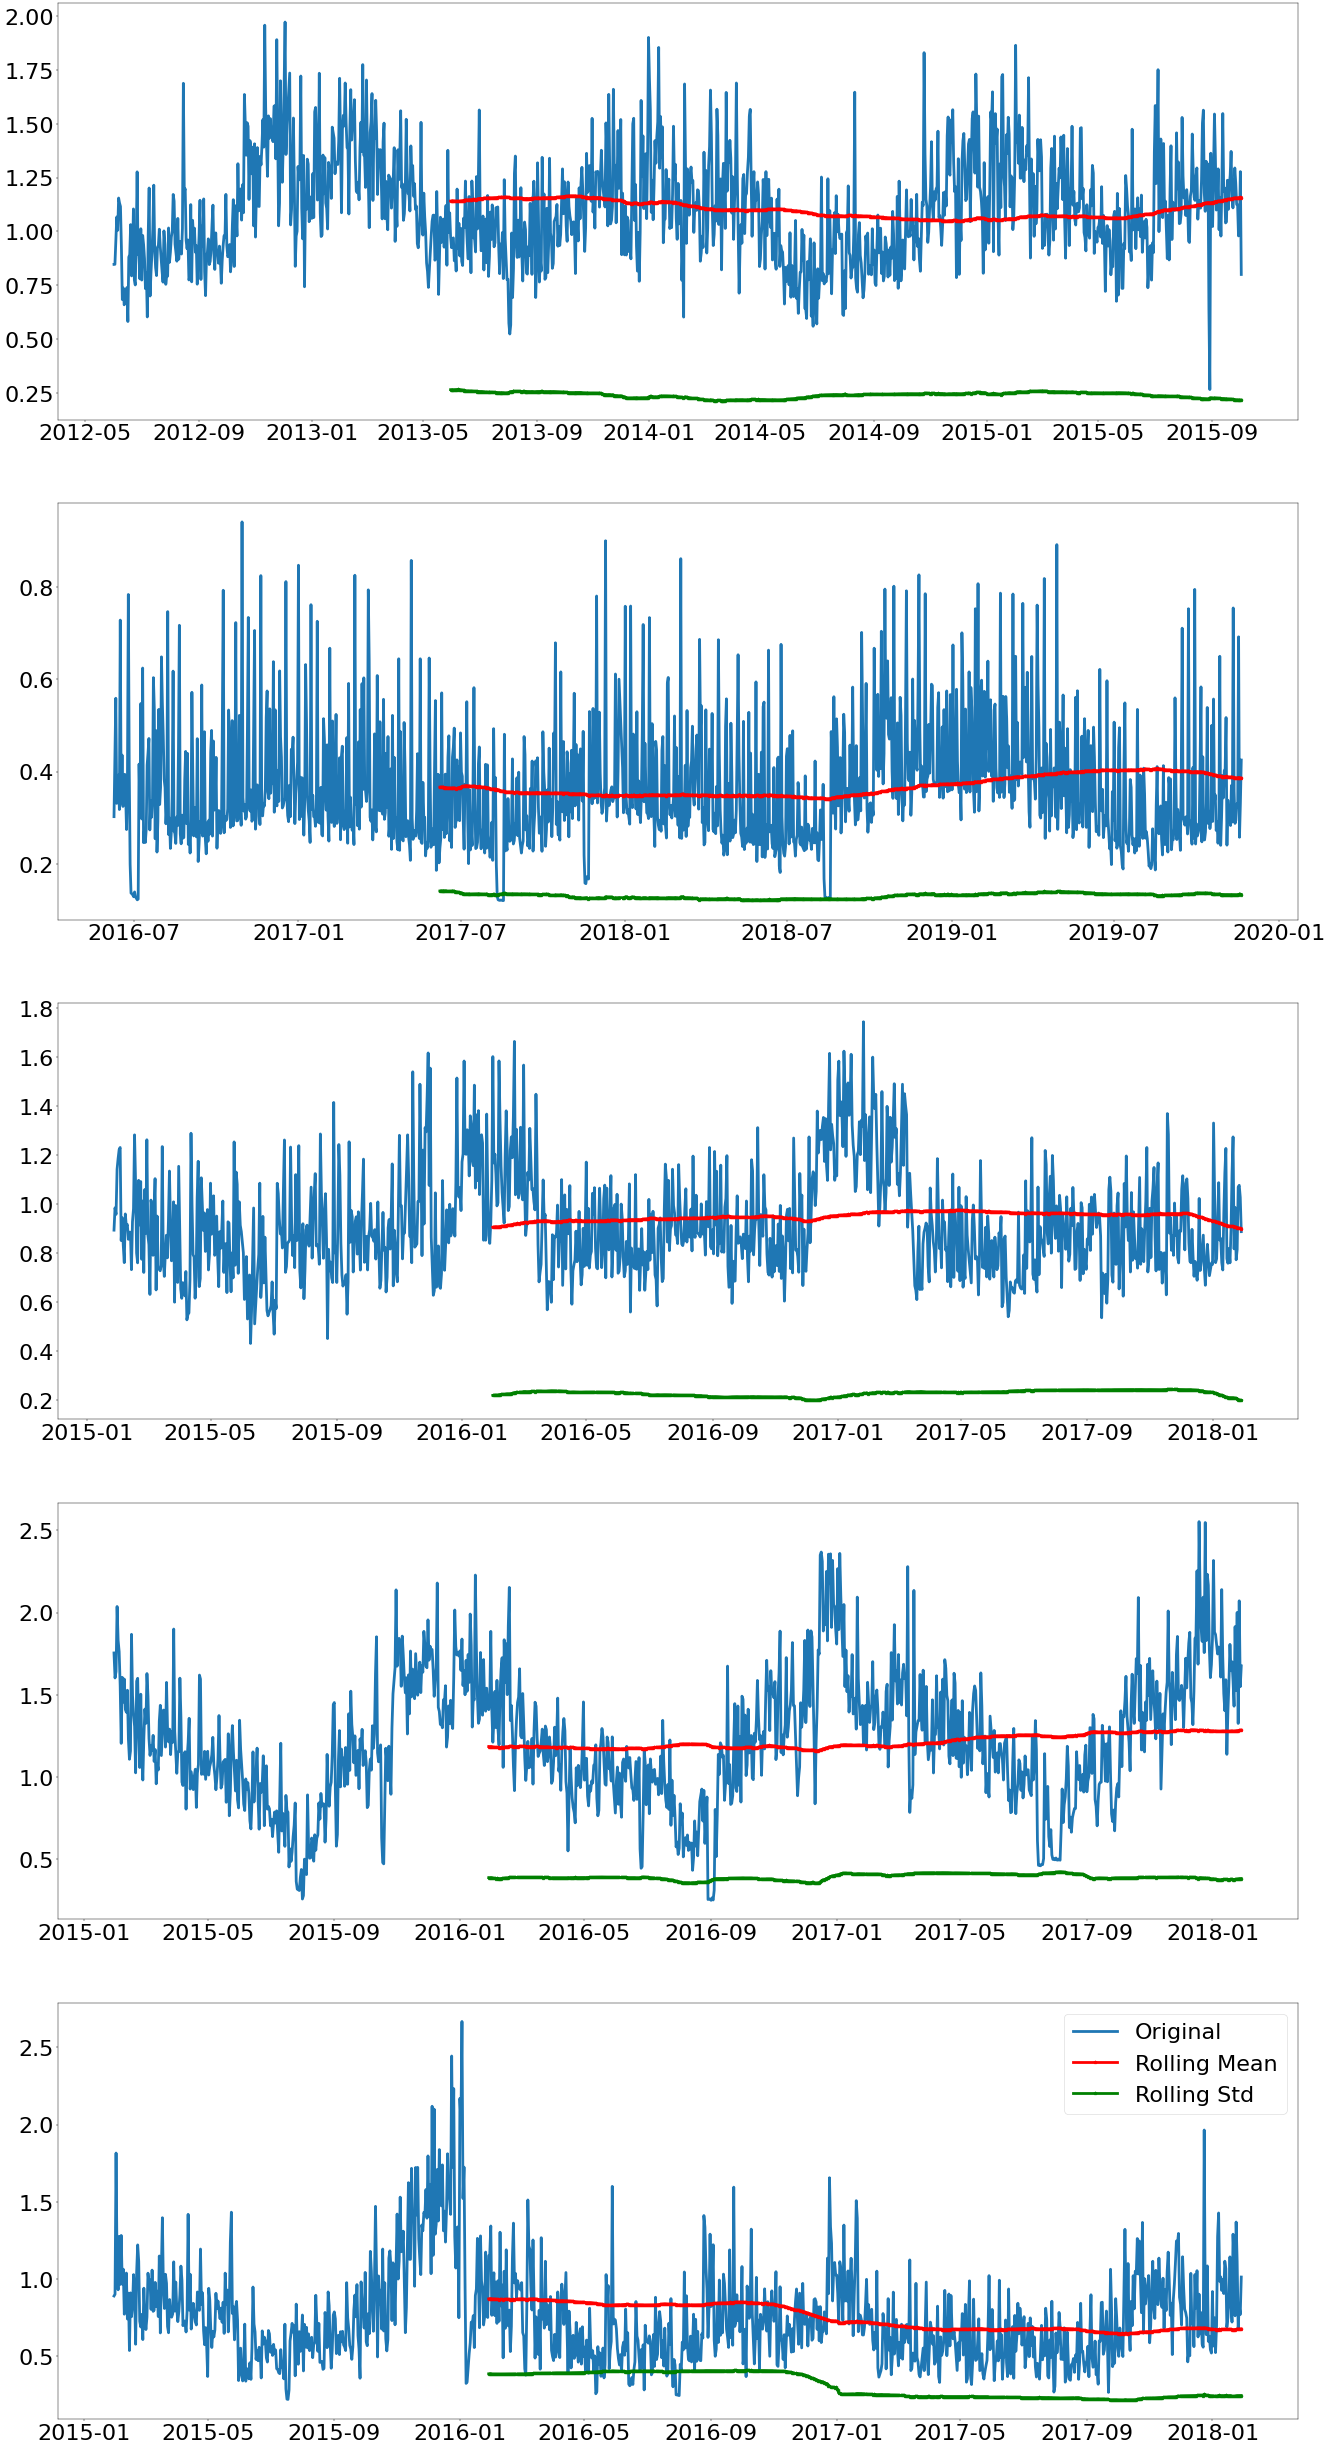

In [11]:
res_amount = 5
plt.figure(figsize=(40,80), dpi=40)
plt.locator_params(axis='x', nbins=3)

for i in range(res_amount):
    ax = plt.subplot(res_amount, 1, 1+i)

    plt.xticks()
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    rollmean = residentials[i]["Global_active_power"].rolling(window=365).mean()
    rollstd = residentials[i]["Global_active_power"].rolling(window=365).std()

    plt.plot(residentials[i].index, residentials[i]["Global_active_power"], label='Original', linewidth='5')
    mean = plt.plot(residentials[i].index, rollmean, '-p', color='red', label='Rolling Mean', linewidth='5')
    std = plt.plot(residentials[i].index, rollstd, '-p', color='green', label='Rolling Std', linewidth='5')
    
plt.legend(loc='best', fontsize=40)
plt.show()

## Normalization, Split and Model Training

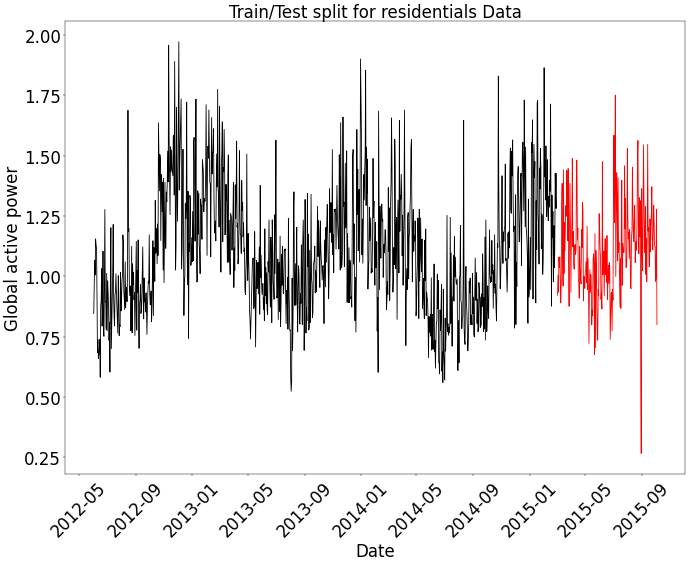

In [12]:
data = residentials[0].copy()

train = data[data.index < pd.to_datetime("2015-03-01", format='%Y-%m-%d')]
test = data[data.index > pd.to_datetime("2015-03-01", format='%Y-%m-%d')]

plt.figure(figsize=(20,15), dpi=40)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Global active power', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks(rotation=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Train/Test split for residentials Data", fontsize=30)
plt.show()

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

y = train["Global_active_power"]
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.92022D-01    |proj g|=  2.24927D-01

At iterate    5    f= -2.12530D-01    |proj g|=  6.32256D-01

At iterate   10    f= -2.29261D-01    |proj g|=  1.51735D-03

At iterate   15    f= -2.30216D-01    |proj g|=  1.05191D-01

At iterate   20    f= -2.34609D-01    |proj g|=  3.78967D-03

At iterate   25    f= -2.34845D-01    |proj g|=  1.47656D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     35      1     0     0   2.549D-06  -2.349D-01
  F = -0.23485305672005027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/brechtl/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/brechtl/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/brechtl/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/brechtl/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

RMSE:  0.5943258158735805


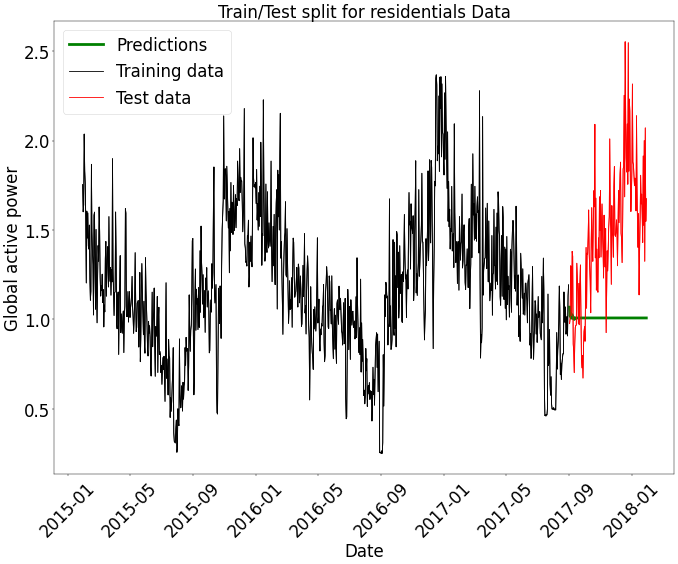

In [14]:
data = residentials[3].copy()

train = data[data.index < pd.to_datetime("2017-09-01", format='%Y-%m-%d')]
test = data[data.index > pd.to_datetime("2017-09-01", format='%Y-%m-%d')]

y = train["Global_active_power"]
ARIMAmodel = ARIMA(y, order = (2,1,12))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.figure(figsize=(20,15), dpi=40)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Global active power', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks(rotation=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Train/Test split for residentials Data", fontsize=30)
plt.plot(y_pred_out, color='green', label = 'Predictions', linewidth="5")
plt.plot(train, color='black', label='Training data')
plt.plot(test, color='red', label='Test data')
plt.legend(fontsize=30)


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Global_active_power"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

In [15]:
#steps = auto_arima(train["Global_active_power"], trace=True)

In [16]:
# import itertools
# import warnings
# import statsmodels.api as sm
# warnings.filterwarnings('ignore')
# # Grid Search
# p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
# pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
# p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's for seasonal parameters
# pdq2 = list(itertools.product(p2,d2,q2)) # similar to code above but for seasonal parameters
# s = 12 # here I use twelve but the number here is representative of the periodicity of the seasonal cycle
# pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
# combs = {}
# aics = []
# # Grid Search Continued
# for combination in pdq:
#     for seasonal_combination in pdqs2:
#         try:
#             model = sm.tsa.statespace.SARIMAX(data, order=combination, seasonal_order=seasonal_combination,
#                                              enforce_stationarity=True,
#                                              enforce_invertibility=True)
#             model = model.fit(disp=False)
#             combs.update({model.aic : [combination, seasonal_combination]})
#             aics.append(model.aic)
#             print(model.aic)
            
#         except:
#             continue
            
# best_aic = min(aics)
# print(best_aic)

In [17]:
import itertools
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                    #print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [18]:
#sarima_grid_search(data,12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18110D-01    |proj g|=  4.01517D-02


 This problem is unconstrained.



At iterate    5    f= -1.22389D-01    |proj g|=  3.19568D-02

At iterate   10    f= -1.23090D-01    |proj g|=  3.96000D-04

At iterate   15    f= -1.23114D-01    |proj g|=  8.78346D-03

At iterate   20    f= -1.23398D-01    |proj g|=  2.09304D-03

At iterate   25    f= -1.23402D-01    |proj g|=  8.10903D-04

At iterate   30    f= -1.23403D-01    |proj g|=  1.01376D-03

At iterate   35    f= -1.23419D-01    |proj g|=  5.97240D-03

At iterate   40    f= -1.23430D-01    |proj g|=  3.18381D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     76      2     0     0   1.376D-04  -1.234D-01
  F = -0.12342978688504751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RMSE:  0.5641945248784486


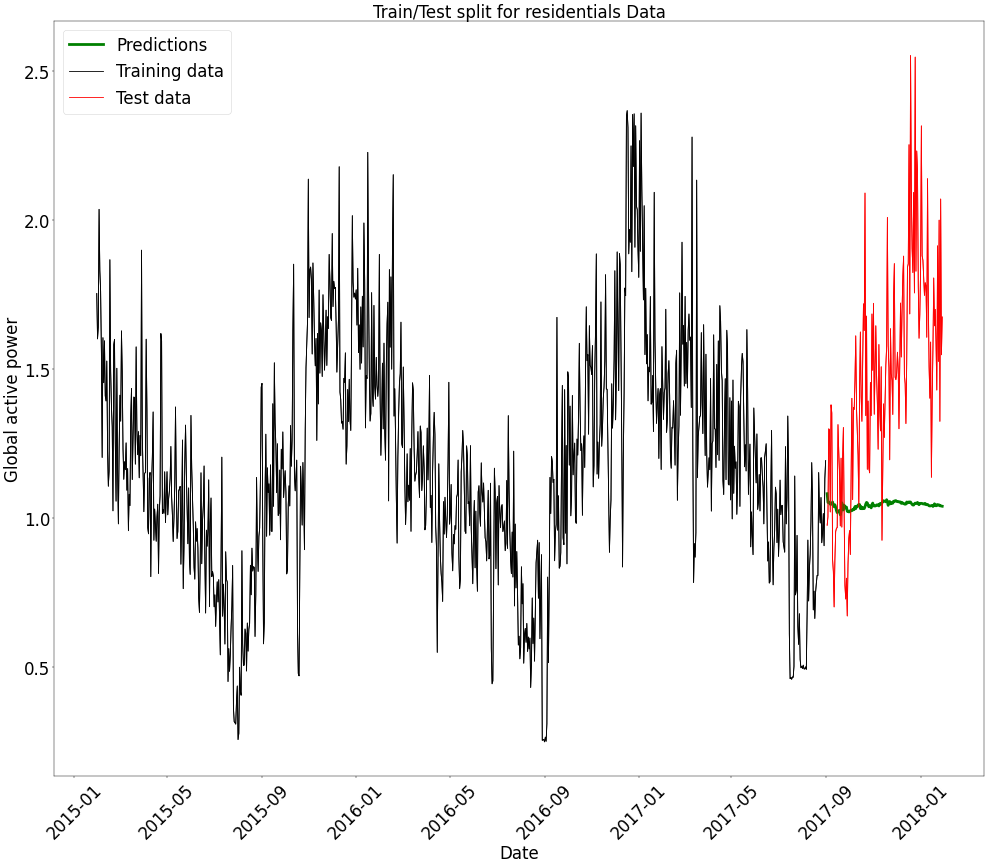

In [55]:
data = residentials[3].copy()

train = data[data.index < pd.to_datetime("2017-09-01", format='%Y-%m-%d')]
test = data[data.index > pd.to_datetime("2017-09-01", format='%Y-%m-%d')]

y = train["Global_active_power"]
ARIMAmodel = sm.tsa.statespace.SARIMAX(y,order=(0, 1, 2),seasonal_order=(2,0,2,30))
ARIMAmodel = ARIMAmodel.fit()



y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

plt.figure(figsize=(30,25), dpi=40)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Global active power', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks(rotation=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Train/Test split for residentials Data", fontsize=30)
plt.plot(y_pred_out, color='green', label = 'Predictions', linewidth="5")
plt.plot(train, color='black', label='Training data')
plt.plot(test, color='red', label='Test data')
plt.legend(fontsize=30)


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Global_active_power"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)